In [2]:
import os
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt
import imageio
import cv2
import random

# Table of contents <a name = 'toc'></a>
1. [Training Data](#trainingdata)
2. [PCA](#pca)
3. [KMeans](#kmeans)
4. [Logistic Regression](#logisticregression)
5. [Neural Net](#neuralnet)

## Training Data <a name = trainingdata></a>
[table of contents](#toc)

In [3]:
data = np.genfromtxt('training_data.csv', delimiter=',')
add_data = np.genfromtxt('training_data_validation.csv',delimiter = ',')
data = np.vstack([data,add_data])
data = data[data[:,-1]!=-1]
data.shape

(1629, 785)

In [4]:
data[:,-1]

array([4., 0., 1., ..., 3., 5., 9.])

label = 6.0


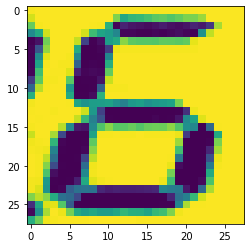

In [5]:
def recover_labeled_img(data,row):
    print("label = {}".format(data[row,-1]))
    plt.imshow(data[row,:-1].reshape((28,28)))
    plt.show()
recover_labeled_img(data,random.randint(0,data.shape[0]))

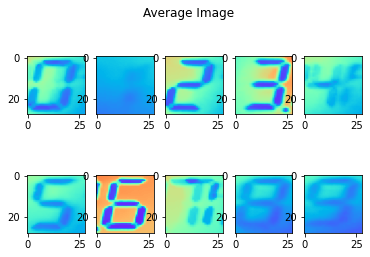

In [7]:
label = 7
def array_avg(label):
    arrays = []
    for i in range(data[data[:,-1] == label].shape[0]):
        arrays.append(data[data[:,-1] == label][i][:784])
    return (sum(arrays)/len(arrays))
f, axes = plt.subplots(ncols = 5,nrows = 2)
axes = axes.flatten()
for i in range(0,10):
    array = array_avg(i)
    axes[i].imshow(array.reshape((28,28)),cmap = 'rainbow',vmax=255,vmin=0)
f.suptitle('Average Image')
plt.savefig('./figures/average_img.png')
plt.show()

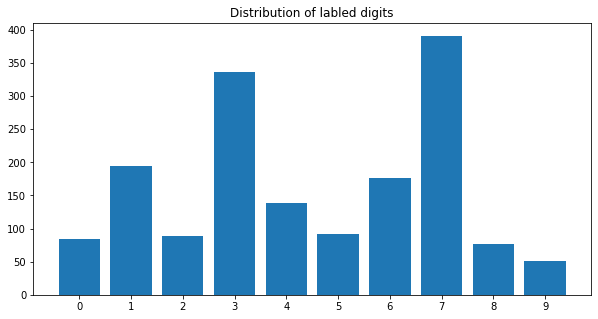

In [8]:
plt.figure(figsize = (10,5))
plt.title('Distribution of labled digits')
labels, counts = np.unique(data[:,-1], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.savefig('./figures/distribution_of_labeled_digits.png')
plt.show()

### Normalizing the Sample Distribution
The training set is very unbalanced as the radon readings favor 3 and 7 heavily.

data_norm_dist shape =  (10000, 785)


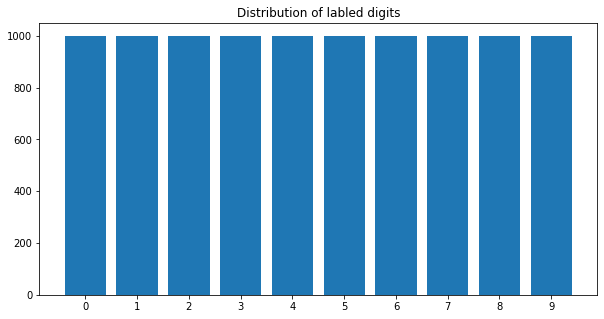

CPU times: user 13.1 s, sys: 11.3 s, total: 24.4 s
Wall time: 24.7 s


In [10]:
%%time
target_pop_size =  10000
example_size = int(target_pop_size/10)
data_norm_dist = data.copy()
while len(data_norm_dist)<target_pop_size:
    for i in range(0,10):
        num_data = data[data[:,-1] == i] 
        #data_norm_dist_temp = data[data[:,-1] != i] # removes num_data so it can be concatenated back in
        while len(num_data)<example_size:
            rand_int = random.randint(-1,len(num_data[:,-1])-1)
            num_data = np.concatenate((num_data,num_data[rand_int].reshape((1,785))),axis = 0)
        data_norm_dist = data_norm_dist[data_norm_dist[:,-1] != i]
        data_norm_dist = np.concatenate((data_norm_dist,num_data.reshape((example_size,785))),axis = 0)
    
print('data_norm_dist shape = ',data_norm_dist.shape)
plt.figure(figsize = (10,5))
plt.title('Distribution of labled digits')
labels, counts = np.unique(data_norm_dist[:,-1], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.savefig('./figures/dist_after_correcting.png')
plt.show()

In [11]:
data = data_norm_dist

### Train Test Split

In [12]:

from sklearn.model_selection import train_test_split

In [13]:


X = data[:,:-1]
y= data[:,-1]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=50)

## PCA <a name = pca></a>
[Table of Contents](#toc)


Try to reduce noise

In [16]:
from sklearn.decomposition import PCA

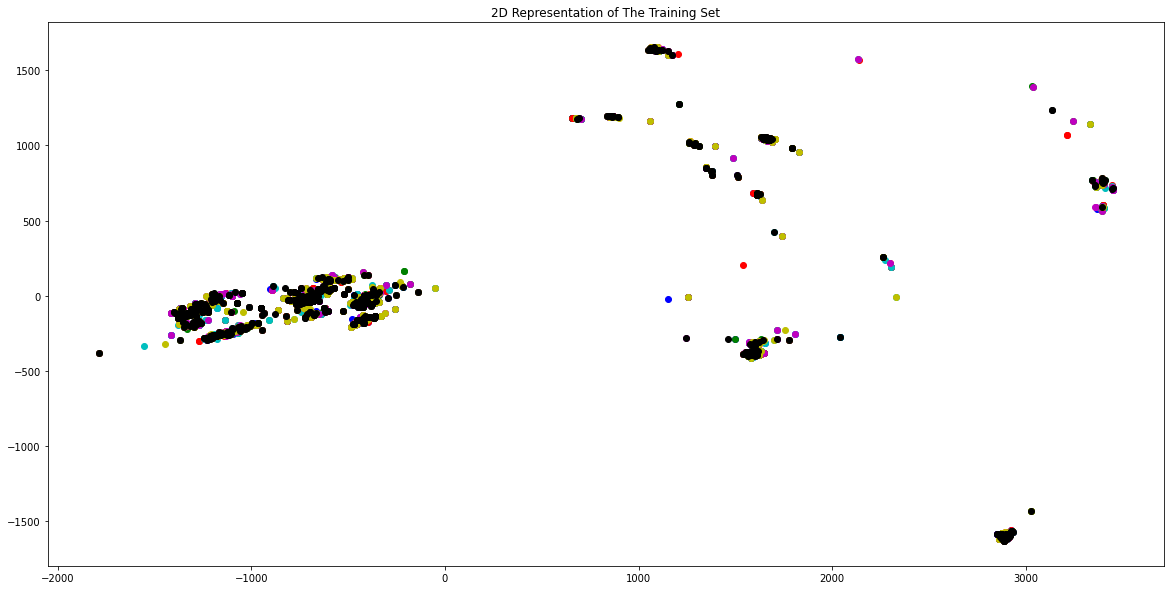

CPU times: user 2min 48s, sys: 1.16 s, total: 2min 49s
Wall time: 2min 53s


In [17]:
%%time
pca_2d = PCA(n_components = 2)
X_train_2d_pca = pca_2d.fit_transform(X_train)
color_dict = {0:'b',1:'g',2:'r',3:'c',4:'m',
             5:'y',6:'k',7:'lime',8:'peru',9:'pink'}
plt.figure(figsize = (20,10))
plt.title('2D Representation of The Training Set')
for i, point in enumerate(X_train_2d_pca):
    plt.scatter(point[0],point[1],color = color_dict[y[i]],label =str(y[i]) )
plt.show()

In [18]:
pca = PCA(n_components = 0.95)
X_train_reduced = pca.fit_transform(X_train)
X_train_recovered = pca.inverse_transform(X_train_reduced)

In [19]:
X_train_reduced.shape

(6700, 7)

In [20]:
X_train_recovered.shape

(6700, 784)

In [21]:
i =12

4.0


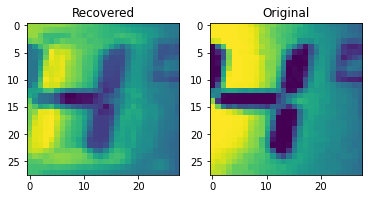

In [22]:

f, axes=plt.subplots(ncols = 2)
axes[0].imshow(X_train_recovered[i].reshape((28,28)))
axes[0].set_title('Recovered')
axes[1].imshow(X_train[i].reshape((28,28)))
axes[1].set_title('Original')
print(y_train[i])
i+=1

## Logistic Regression <a name = logisticregression></a>
[table of contents](#toc)

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
clf = LogisticRegression(C = 0.01, random_state=42,penalty='l2').fit(X_train, y_train)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [27]:
clf.score(X_test,y_test)

1.0

In [28]:
y_pred_lr = clf.predict(X_test)

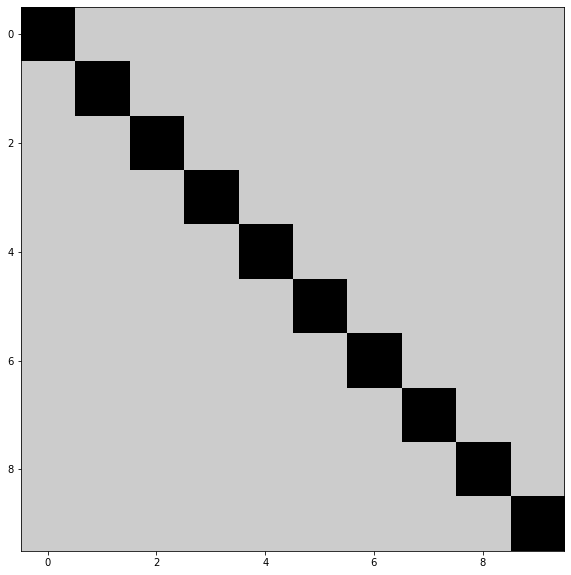

In [29]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (10,10))
plt.imshow(confusion_matrix(y_test, y_pred_lr),cmap='nipy_spectral_r', vmin=0, vmax=255)
plt.savefig('./figures/log_reg_conf.png')

In [30]:
y_test[y_test != y_pred_lr]

array([], dtype=float64)

In [227]:
from joblib import dump, load
#dump(clf, 'logistic_regression.joblib') 


['logistic_regression.joblib']

## Neural Network <a name = neuralnet></a>
[table of contents](#toc)

In [31]:
import tensorflow as tf
import tensorflow.keras as keras

In [32]:
data_1 = data[data[:,-1]!=-1]
y = data_1[:,-1]
X = data_1[:,:-1]/255
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=50)

In [33]:
X[:].shape

(10000, 784)

In [34]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape = (784)))
model.add(keras.layers.Dense(50,activation='relu'))
model.add(keras.layers.Dense(50,activation='relu'))
model.add(keras.layers.Dense(50,activation='relu'))
model.add(keras.layers.Dense(50,activation='relu'))
model.add(keras.layers.Dense(10,activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
Total params: 47,410
Trainable params: 47,410
Non-trainable params: 0
_________________________________________________________________


In [35]:
weights, biases = model.layers[1].get_weights()

In [36]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
#loss_fn = keras.losses.CategoricalCrossentropy()
model.compile(loss=loss_fn,
             optimizer = 'adam',
             metrics = ['accuracy'])

Epoch 1/50
210/210 [==============================] - 1s 4ms/step - loss: 1.1661 - accuracy: 0.6103 - val_loss: 0.5150 - val_accuracy: 0.8485
Epoch 2/50
210/210 [==============================] - 1s 3ms/step - loss: 0.3077 - accuracy: 0.9142 - val_loss: 0.1828 - val_accuracy: 0.9230
Epoch 3/50
210/210 [==============================] - 1s 3ms/step - loss: 0.1121 - accuracy: 0.9721 - val_loss: 0.1292 - val_accuracy: 0.9664
Epoch 4/50
210/210 [==============================] - 1s 3ms/step - loss: 0.0751 - accuracy: 0.9827 - val_loss: 0.0657 - val_accuracy: 0.9906
Epoch 5/50
210/210 [==============================] - 1s 3ms/step - loss: 0.0366 - accuracy: 0.9931 - val_loss: 0.0304 - val_accuracy: 0.9955
Epoch 6/50
210/210 [==============================] - 1s 3ms/step - loss: 0.0342 - accuracy: 0.9934 - val_loss: 0.0304 - val_accuracy: 0.9942
Epoch 7/50
210/210 [==============================] - 1s 3ms/step - loss: 0.0400 - accuracy: 0.9912 - val_loss: 0.0388 - val_accuracy: 0.9924
Epoch 

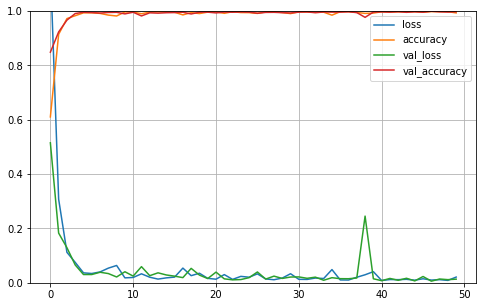

In [37]:
history = model.fit(X_train, y_train, epochs = 50,
                   validation_data = (X_test, y_test))
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

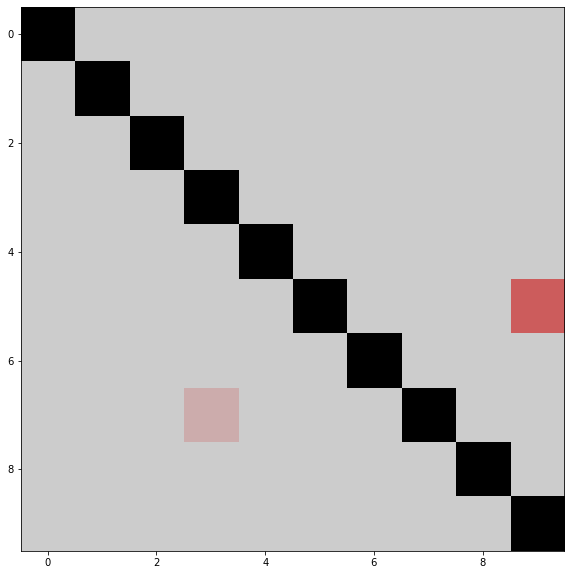

In [38]:
from sklearn.metrics import confusion_matrix
y_pred_nn = model.predict(X_test)
y_pred_nn = [x.argmax() for x in y_pred_nn]
plt.figure(figsize=(10,10))
plt.imshow(confusion_matrix(y_test, y_pred_nn),cmap = 'nipy_spectral_r', vmin=0, vmax=255)
plt.savefig('./figures/nn_confusion.png')
plt.show()

In [39]:
print('labels = ',y_test[y_test != y_pred_nn])
print('predictions = ',np.array(y_pred_nn)[y_pred_nn != y_test])

labels =  [5. 5. 7. 5. 5. 5. 5. 5. 7.]
predictions =  [9 9 3 9 9 9 9 9 3]


In [53]:
from joblib import dump, load
# nn_model = model
# dump(nn_model, 'deeper_nn_model.joblib') 

INFO:tensorflow:Assets written to: ram://c878c50f-df35-4d3d-8d58-84d5f108a653/assets


['deeper_nn_model.joblib']

### Radom Gut Check

In [24]:
i = random.randint(0,405)
m_prediction = model.predict(X_test[i].reshape(1,-1)).round(2)
lr_pred = clf.predict(X_test[i].reshape(1,-1))[0]
print('logistic reg pred = {}'.format(lr_pred))
print('nn prediction = {}'.format(m_prediction.argmax()))
print('nn probabiliy = {}'.format(m_prediction.max()))
plt.imshow(X_test[i].reshape((28,28)))
plt.show()

NameError: name 'clf' is not defined

### Review Low Confidence Prediction

In [45]:
nn_y_pred = model.predict(X_test).round(2)
low_confidence_prob = []
low_confidence_pred = []
indexes = []
for i,pred in enumerate(nn_y_pred):
    if pred.max()<0.9:
        low_confidence_prob.append(pred.max())
        low_confidence_pred.append(pred.argmax())
        indexes.append(i)
low_confidence = pd.DataFrame()
i = 0
for prob, pred in zip(low_confidence_prob,low_confidence_pred):
    low_confidence.loc[i,'index'] = indexes[i]
    low_confidence.loc[i,'log_reg_probability'] = prob
    low_confidence.loc[i,'prediction'] = pred
    i+=1
low_confidence.sort_values(by = 'log_reg_probability',ascending = False)

,index,log_reg_probability,prediction
0,547.0,0.84,7.0
3,2165.0,0.76,1.0
1,840.0,0.75,5.0
2,1866.0,0.53,7.0
4,2737.0,0.53,7.0


nn prediction = 7
nn probabiliy = 0.5299999713897705


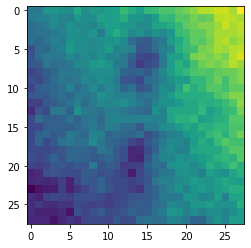

In [51]:
i = 4
m_prediction = model.predict(X_test[indexes[i]].reshape(1,-1)).round(2)
#lr_pred = int(clf.predict(X_test[indexes[i]].reshape(1,-1))[0])
#lr_prob = round(clf.predict_proba(X_test[indexes[i]].reshape(1,-1)).max(),2)
#print('logistic reg prediction = {}'.format(lr_pred))
#print('logistic reg probability = {}'.format(lr_prob))
print('nn prediction = {}'.format(low_confidence_pred[i]))
print('nn probabiliy = {}'.format(round(low_confidence_prob[i],2)))
plt.imshow(X_test[indexes[i]].reshape((28,28)))
plt.show()